# Preprocess

## なにをするのか

Datasetを機械学習モデルが認識しやすい形に変換し、Preprocessed Datasetを作成します。必要に応じデータ同士を組み合わせて新しいデータを作るFeature Engineeringを行います。

## なぜやるのか

人間に理解しやすいデータと機械学習モデルにとって理解しやすいデータは異なります。また、テキストや文字データはそのままでは機械学習モデルに入力できないため、数値表現に変換する必要があります。きちんとした定義はありませんが、データの欠損や外れ値の除去などネガティブな要素を低減するための処理を前処理、データの特徴をより強調したり学習しやすい形式に変換する処理をFeature Engineeringと呼びます。

## どうやるのか

データには画像、テキスト、音声、数値項目、カテゴリ項目など様々な種類があり、データの種類ごとに前処理、Feature Engineeringの手法は異なります。本章は基本的な数値項目とカテゴリ項目の前処理についてプログラミング演習を行います。

### プログラミング演習

#### 数値項目の前処理

数値項目の代表的な前処理は標準化です。数値項目の値を平均0、分散1に値をそろえる処理です。項目によって値の範囲がばらばらである時、標準化を行うことで学習がしやすくなります。演習では`scikit-learn`の`StandardScaler`を用いた標準化の方法と、標準化の効果を学びます。

まず、データを読み込みます。

In [1]:
from pathlib import Path
import pandas as pd


raw_data_path = Path("../data/raw/house_prices.csv")
house_price_df = pd.read_csv(raw_data_path, na_values="?")

`SalePrice`を[`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)で標準化してみましょう。`StandardScaler`は標準化を行うためのクラスです。標準化前の`SalePrice`の統計量は次の通りです。

In [2]:
house_price_df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

`StandardScaler`で標準化してみましょう。

In [3]:
from sklearn.preprocessing import StandardScaler


saleprice_scaler = StandardScaler()
saleprice_scaler.fit(house_price_df["SalePrice"].values.reshape((-1, 1)))
scaled_saleprice = saleprice_scaler.transform(house_price_df["SalePrice"].values.reshape((-1, 1)))
pd.DataFrame(scaled_saleprice).describe()

,0
count,1.460000e+03
mean,1.362685e-16
std,1.000343e+00
min,-1.838704e+00
25%,-6.415162e-01
50%,-2.256643e-01
75%,4.165294e-01
max,7.228819e+00


平均(mean)は0、標準偏差は1に近くなっていることがわかります。

*Exercise: SalePrice以外の数値項目で標準化を試してみましょう 例: GrLivArea, GarageCars, GarageArea*

In [4]:
scaler_target_name = "GrLivArea"
scaler = StandardScaler()
scaler.fit(house_price_df[scaler_target_name].values.reshape((-1, 1)))
scaled_value = scaler.transform(house_price_df[scaler_target_name].values.reshape((-1, 1)))
before_after = pd.DataFrame({
    "Before": house_price_df[scaler_target_name],
    "After": pd.Series(scaled_value.flatten())})

before_after.describe()

,Before,After
count,1460.000000,1.460000e+03
mean,1515.463699,-1.277517e-16
std,525.480383,1.000343e+00
min,334.000000,-2.249120e+00
25%,1129.500000,-7.347485e-01
50%,1464.000000,-9.797004e-02
75%,1776.750000,4.974036e-01
max,5642.000000,7.855574e+00


標準化の効果を、データ同士の分布から確認します。SalePriceとそれ以外の数値項目はデータの値の範囲が異なります。散布図をプロットすると、値が大きい方の軸にデータが偏ることがわかります。

<AxesSubplot:xlabel='GrLivArea(Before)', ylabel='SalePrice'>

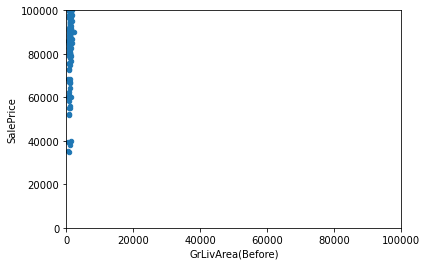

In [5]:
pd.DataFrame({
    "SalePrice": house_price_df["SalePrice"],
    f"{scaler_target_name}(Before)": before_after["Before"]
}).plot.scatter(x=f"{scaler_target_name}(Before)", y="SalePrice", xlim=[0, 100000], ylim=[0, 100000])

標準化を行うことでお互いの値の範囲が平均0、分散1になります。散布図を描くと、値の範囲の異なりによる偏りが解消されることがわかります。

<AxesSubplot:xlabel='GrLivArea(After)', ylabel='SalePrice(Scaled)'>

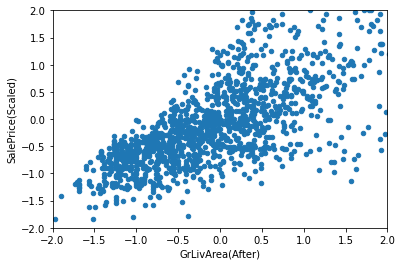

In [6]:
pd.DataFrame({
    "SalePrice(Scaled)": pd.Series(scaled_saleprice.flatten()),
    f"{scaler_target_name}(After)": before_after["After"]
}).plot.scatter(x=f"{scaler_target_name}(After)", y="SalePrice(Scaled)", xlim=[-2, 2], ylim=[-2, 2])

#### カテゴリ項目の前処理

カテゴリ項目の前処理は、数値に変換することです。カテゴリ項目とは、ドロップダウンリストやラジオボタンから選択するような項目です。項目の値は文字やテキストなので、そのままでは機械学習モデルで扱うことができません。

カテゴリ項目を数値に変換する方法は2つあります。1つ目は、単純に項目ごと上から順に番号を割り当てる手法です。`scikit-learn`では`OrdinalEncoder`で実装できます。`ExterCond`を`OrdinalEncoder`で数値にしてみましょう。

In [7]:
house_price_df["ExterCond"].value_counts()

TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

In [8]:
from sklearn.preprocessing import OrdinalEncoder


ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(house_price_df["ExterCond"].values.reshape((-1, 1)))
ordinal_encoded_category = ordinal_encoder.transform(house_price_df["ExterCond"].values.reshape((-1, 1)))
pd.Series(ordinal_encoded_category.flatten()).value_counts()

4.0    1282
2.0     146
1.0      28
0.0       3
3.0       1
dtype: int64

数値に変換できていることがわかります。ただ、数値にすることで項目間に順列性が発生します。日本、アメリカ、イギリス、という項目があったとして、これを数値に変換すると0,1,2となり日本<アメリカという数値上の関係が発生してしまいます。順列関係が好ましくない場合は、2つ目の方法として値ごとに項目を分離します。「日本」「アメリカ」「イギリス」という項目を作って、チェックがあれば1、それ以外は0とします。`scikit-learn`では`OnehotEncoding`で実装できます。

In [9]:
from sklearn.preprocessing import OneHotEncoder


one_hot_encoder = OneHotEncoder(handle_unknown="ignore")
one_hot_encoder.fit(house_price_df["ExterCond"].values.reshape((-1, 1)))
encoded_category = one_hot_encoder.transform(house_price_df["ExterCond"].values.reshape((-1, 1)))
pd.DataFrame(encoded_category.toarray().astype("int64"), columns=one_hot_encoder.categories_)

,Ex,Fa,Gd,Po,TA
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
1455,0,0,0,0,1
1456,0,0,0,0,1
1457,0,0,1,0,0
1458,0,0,0,0,1


数値項目、カテゴリ項目の前処理については以上となります。前処理に加えて、データを加工したり組み合わせるFeature Engineeringを行うことで、データの傾向を顕著に表す特徴を作成する場合もあります。詳細はReferenceを参照してください。

#### 前処理の実装

では、実際に前処理を行うプログラムを作成していきます。

今回は数値の項目には`StandardScaler`、カテゴリの項目には`OrdinalEncoder`を適用することとします。  
データの前提条件として、Analyzeの結果より`PoolQC`など空白が多い項目を除外しています。

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer


# 空白の割合が高い項目を除外
formatted_df = house_price_df.drop(columns=["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"], axis=1)

# 数値項目、予測項目、カテゴリ項目を仕分け
numerical_columns = formatted_df.select_dtypes("number").columns
categorical_columns = formatted_df.columns.difference(numerical_columns)
numerical_columns = numerical_columns.drop("SalePrice")
columns = numerical_columns.tolist() + ["SalePrice"] + categorical_columns.tolist()
formatted_df = formatted_df[columns]

encoder = make_column_transformer(
        (StandardScaler(), numerical_columns),
        (StandardScaler(), ["SalePrice"]),
        (OrdinalEncoder(), categorical_columns),
)

Trainで使用する学習用データ、Testで使用する評価用データに分割を行います。前処理済みのデータを作成するのは学習用データのみとし、評価用データは評価時に前処理を行うことにします。評価をなるべく実際のデータに近い状態から行うようにするためです。

In [11]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(formatted_df, test_size=0.3) 

Analyzeの結果70万ドルを超える高額住宅が予測に悪影響を与えそうなことがわかっているため、学習用データから除外します。

In [12]:
train_df = train_df[train_df["SalePrice"] < 700000]

学習用データの前処理を実行します。欠損値については中央値で穴埋めを行います。

In [13]:
encoder.fit(pd.concat([train_df, test_df]))
preprocessed_train = encoder.transform(train_df)
preprocessed_train_df = pd.DataFrame(preprocessed_train, columns=columns)
preprocessed_train_df = preprocessed_train_df.fillna(preprocessed_train_df.median())

前処理済みの学習データは次のようになります。

In [14]:
preprocessed_train_df.head(5)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,MSZoning,MasVnrType,Neighborhood,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
0,1.694636,-0.872215,-0.289375,-0.201389,0.654978,-0.516787,1.084470,0.927217,0.017048,-0.972807,...,3.0,1.0,5.0,2.0,1.0,1.0,4.0,8.0,1.0,0.0
1,-1.580912,0.309804,-0.825127,-0.020976,0.654978,0.381893,-1.664144,-1.688593,-0.575503,-0.972807,...,4.0,2.0,17.0,2.0,1.0,1.0,4.0,8.0,1.0,0.0
2,1.587902,-0.163004,-0.783915,-0.434824,-0.070070,0.381893,-1.531681,0.249044,-0.575503,-0.393005,...,3.0,2.0,18.0,2.0,1.0,1.0,4.0,8.0,1.0,0.0
3,-0.404466,1.491823,-0.083316,-0.733007,0.654978,-0.516787,1.051354,0.927217,-0.474881,-0.972807,...,3.0,1.0,0.0,2.0,1.0,1.0,4.0,8.0,1.0,0.0
4,0.188501,0.428006,0.823341,-0.241481,-0.795118,-0.516787,-2.425809,-0.961979,-0.575503,-0.972807,...,4.0,2.0,17.0,0.0,1.0,3.0,4.0,8.0,1.0,0.0


Preprocessの終わりに、前処理済みの学習用データと評価用データを保存します。評価用データは前処理していないため、`interim`に保存しています。

In [15]:
preprocessed_train_df.to_csv(Path("../data/processed/train.csv"), index=False)
test_df.to_csv(Path("../data/interim/test.csv"), index=False)

評価を行う際時に前処理を行う必要があるため、前処理のプロセスも保存します。

In [16]:
from joblib import dump


encoder_path = Path("../model/encoder.joblib")
dump(encoder, encoder_path) 

['../model/encoder.joblib']

### コミュニケーション演習

データサイエンティストとして次のPreprocessを行いました。項目に対し適切な前処理を行っているか確認するには、誰にどのような質問をすべきでしょうか。

* 数値項目には標準化を行う`StandardScaler`を適用しました。
* カテゴリ項目には**順列性が生まれる**`OrdinalEncoder`を適用しました。
* Analyze結果に基づいた**データの除外**を行いました。


| 英語名             | 日本語名                   | 役割                                                                 |
|--------------------|----------------------------|------------------------------|
| Product Manager    | プロダクトマネージャー     | ユーザー体験を向上させるために実装すべきソフトウェア機能を定義する。 |
| Business Analyst   | ビジネスアナリスト         | 解決すべきビジネス上の問題を定義する                                 |
| Data Analyst       | データアナリスト           | データの可視化と分析で問題を定量的に特定する。                       |
| Architect          | アーキテクト               | ソフトウェアアーキテクチャ全体を設計する。                           |
| DevOps Engineer    | DevOpsエンジニア           | ソフトウェアの開発・運用プロセスを自動化する。                       |
| Software Engineer  | ソフトウェアエンジニア     | ソフトウェアの開発を行う。                                           |
| Operator           | 業務担当者                 | ソフトウェアを利用し業務を行う。                                     |
| System Admin       | システム管理者             | サービスの挙動を監視する。                                           |
| IT Auditor         | IT監督者                   | システムや会社全体の権限管理や監査を行う。                           |
| Data architect     | データアーキテクト         | データを管理する基盤を設計、運用する。                               |
| Domain Expert      | 業務有識者                 | 深い業務知識を持ちデータの意味やあるべき状態について定義する。       |
| Data Scientist     | データサイエンティスト     | 機械学習モデルを開発する。                                           |


#### 質問例

* Data Analyst
   * 現在分析を行うにどのような前処理をしていますか。
* Product Manager
   * 機械学習モデルの構築において、Analyzeにおいて除外すべきと判断したデータを除外しました(報告)。

## Next Step

[Train](05_train.ipynb)

## References

1. 本橋 智光 and 株式会社ホクソエム. [前処理大全［データ分析のためのSQL/R/Python実践テクニック］](https://www.amazon.co.jp/dp/B07C3JFK3V/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1). 2018.
2. Alice Zheng, Amanda Casari and 株式会社ホクソエム. [機械学習のための特徴量エンジニアリング ―その原理とPythonによる実践](https://www.amazon.co.jp/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%81%AE%E3%81%9F%E3%82%81%E3%81%AE%E7%89%B9%E5%BE%B4%E9%87%8F%E3%82%A8%E3%83%B3%E3%82%B8%E3%83%8B%E3%82%A2%E3%83%AA%E3%83%B3%E3%82%B0-%E2%80%95%E3%81%9D%E3%81%AE%E5%8E%9F%E7%90%86%E3%81%A8Python%E3%81%AB%E3%82%88%E3%82%8B%E5%AE%9F%E8%B7%B5-%E3%82%AA%E3%83%A9%E3%82%A4%E3%83%AA%E3%83%BC%E3%83%BB%E3%82%B8%E3%83%A3%E3%83%91%E3%83%B3-Alice-Zheng/dp/4873118689). 2019. 
3. Henrik Brink, Joseph Richards and Mark Fetherolf [Real-World Machine Learning](https://www.amazon.co.jp/dp/B097834SKF/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1). 2016.

関連するAWSのサービス

1. Data Wrangler
2. SageMaker Processing
